In [1]:
import LDAQ #custom version of LDAQ --> should be installed properly via pip
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

In [2]:
def simulate_signal(t, f1, f2):
    """
    first argument must be time.
    If multi_processing is True, then the function must be pickable and
    all libraries must be imported inside the function.
    """
    #import numpy as np
    sig1 = np.sin(2*np.pi*f1*t) + np.random.rand(len(t))*0.3
    sig2 = np.cos(2*np.pi*f2*t) + np.random.rand(len(t))*0.3
    return np.array([sig1, sig2]).T

fs = 1_000_000
acq_simulated = LDAQ.simulator.SimulatedAcquisition(acquisition_name='sim')
acq_simulated.set_simulated_data(simulate_signal, channel_names=["ch1", "ch2"], sample_rate=fs, args=(84, 120)) # use function
#acq_simulated.run_acquisition(1.0)

In [3]:
#fs = 1_000_000
#ni_task = LDAQ.national_instruments.NITask("input_task", sample_rate=fs)
#ni_task.add_channel(...)
#acq_ni = LDAQ.national_instruments.NIAcquisition(task_name=ni_task, acquisition_name="NI")

In [3]:
vis = LDAQ.Visualization(refresh_rate=100)
vis.add_lines((0,0), source="sim", channels=["ch1"], t_span=5.0)
vis.add_lines((1,0), source="sim", channels=["ch2"], t_span=5.0)

In [4]:
ldaq = LDAQ.Core(acquisitions=[acq_simulated], visualization=vis)
ldaq

Acquisition sources (index, name):
	0 - sim

Generation sources (index, name):
	None

Additional check events:
	None

Trigger settings:
	- duration [sec]      None
	- source              None
	- channel             None
	- level               None
	- presamples          None
	- type                None

In [5]:
ldaq.run(1.)

closing app
closing app


In [6]:
measurement = ldaq.get_measurement_dict()
data = measurement["sim"]
data

{'time': array([0.00000e+00, 1.00000e-06, 2.00000e-06, ..., 9.99997e-01,
        9.99998e-01, 9.99999e-01], shape=(1000000,)),
 'channel_names': ['ch1', 'ch2'],
 'data': array([[1.02266811, 0.56584584],
        [1.18440392, 0.6238755 ],
        [1.14398674, 0.61553278],
        ...,
        [1.25528318, 0.54383817],
        [1.04846932, 0.58188216],
        [1.27396046, 0.47319634]], shape=(1000000, 2)),
 'sample_rate': 1000000}

In [7]:
time = data["time"]
fs = data["sample_rate"]
raw_data = data["data"]

ch1_data = raw_data[:, data["channel_names"].index("ch1")]
ch2_data = raw_data[:, data["channel_names"].index("ch2")]

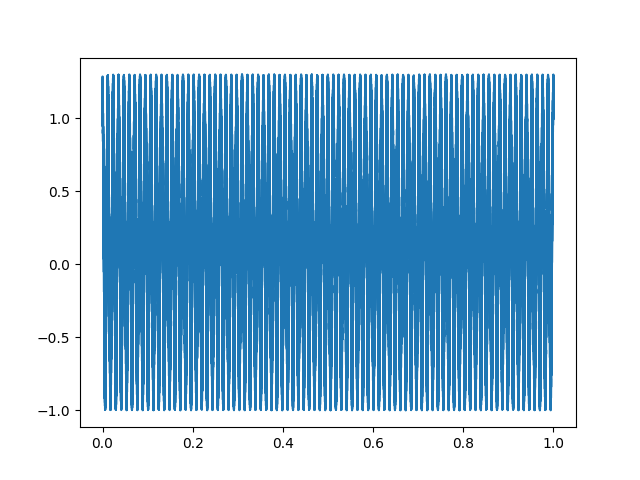

In [8]:
%matplotlib widget
plt.plot(time, ch1_data)